# EDA
To prepare for modeling, we need a deeper understanding of the features we are working with, as well as those we are trying to predict. Some potential steps to take, along with further data cleaning along the way:

- distribution of ratings
- date FA, person FA (filtering + value counts, will take feature engineering and abstraction), areas, route types
- correlation between ratings and year established (only numeric variable)
- word counts per, characters per, etc.
- correlation between ratings and length of description etc?
- preprocessing - tokenize, lemmatize, then round 2 EDA bigrams, ngrams, etc.
- word2vec could be used to look at similarities between route descriptions
- unsupervised learning to group routes and cluster

### Imports

In [451]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc("font", size=16)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("axes", labelsize=14)
plt.rc("legend", fontsize=12)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Read in Data and Summary Statistics

In [452]:
routes = pd.read_csv('./data/routes.csv')

In [453]:
routes.head()

,route_name,safety,fa,description,location,protection,grade.YDS,type.trad,metadata.parent_lnglat,metadata.parent_sector,...,type.alpine,type.snow,type.mixed,type.ice,text_combined,lemmatized_text_combined,grade_reduced,plus_minus,year_established,stratify
0,Gravel Pit,NaN,Jason Milford/ Matt Schutz Spring 2020,Goes up slab on bolts to steep corner on gear....,NaN,"Chains on top, can lower off easy. Pro to 3"" a...",5.12b/c,1,"[-118.20202, 35.4963]",Beerhorn Crag,...,0,0,0,0,goes up slab on bolts to steep corner on gear ...,go slab bolt steep corner gear leave corner st...,12,0,2020.0,120
1,Random Impulse,NaN,"""Unknown"" or",Some fun moves broken up by a few scree filled...,25 feet to the right of Deep Springs Education.,A small assortment of cams and maybe a nut or two,5.7,1,"[-118.13831, 37.3129]",Westgard Pass East Side (Hwy 168),...,0,0,0,0,some fun moves broken up by a few scree filled...,fun move break scree fill ledge big bush crux ...,7,0,NaN,70
2,Orange Crush,NaN,"Wade Griffith, Sterling Killion, Scott Williams",Pretty cool orange arete that sports some inte...,The route is located on the far southern shoul...,7 QD's,5.11b/c,0,"[-119.3094, 37.1667]",Yeti Dome (aka Musick Mountain),...,0,0,0,0,pretty cool orange arete that sports some inte...,pretty cool orange arete sport interesting cli...,11,0,NaN,110
3,Wimovi Wonder Winos,NaN,Kroll and McHam,Climb the most open looking slab on the more e...,"Upper right of the wall, more facing the road.",Bolts,5.10-,0,"[-119.31008, 37.14469]",Wimovi Pluton,...,0,0,0,0,climb the most open looking slab on the more e...,climb open look slab eastern aspect wall close...,10,-1,NaN,10-1
4,Stand and Fall,NaN,Bryan Carroll,Best route on the wall. Crux is moving from to...,Start at obious fist-sized crack in center of ...,Use tree with 14 inch diameter at top to set u...,5.10-,0,"[-119.1022, 37.2914]",Wilderness Wall,...,1,0,0,0,best route on the wall crux is moving from to...,good route wall crux move crack thin seam time...,10,-1,NaN,10-1


In [454]:
routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127008 entries, 0 to 127007
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   route_name                127005 non-null  object 
 1   safety                    13129 non-null   object 
 2   fa                        125837 non-null  object 
 3   description               126520 non-null  object 
 4   location                  99721 non-null   object 
 5   protection                126371 non-null  object 
 6   grade.YDS                 127008 non-null  object 
 7   type.trad                 127008 non-null  int64  
 8   metadata.parent_lnglat    127008 non-null  object 
 9   metadata.parent_sector    127008 non-null  object 
 10  metadata.mp_route_id      127002 non-null  float64
 11  metadata.mp_sector_id     127008 non-null  int64  
 12  metadata.mp_path          127008 non-null  object 
 13  type.sport                127008 non-null  i

I am a bit concerned by the number of null values in year_established, which I thought would be an interesting column to have outside of our text features. I will keep it for EDA, but it cannot be used for modeling without some serious imputation. 

In [455]:
routes.describe().T

,count,mean,std,min,25%,50%,75%,max
type.trad,127008.0,4.668289e-01,4.989004e-01,0.0,0.0,0.0,1.0,1.0
metadata.mp_route_id,127002.0,1.106925e+08,4.992321e+06,105714703.0,106401783.5,108372266.5,114122467.5,121970893.0
metadata.mp_sector_id,127008.0,1.089633e+08,4.386991e+06,105714297.0,105876123.0,106751834.0,110935877.0,121959816.0
type.sport,127008.0,4.938272e-01,4.999639e-01,0.0,0.0,0.0,1.0,1.0
type.tr,127008.0,1.474632e-01,3.545684e-01,0.0,0.0,0.0,0.0,1.0
type.alpine,127008.0,3.621032e-02,1.868138e-01,0.0,0.0,0.0,0.0,1.0
type.snow,127008.0,1.251890e-03,3.536004e-02,0.0,0.0,0.0,0.0,1.0
type.mixed,127008.0,8.818342e-04,2.968271e-02,0.0,0.0,0.0,0.0,1.0
type.ice,127008.0,8.739607e-04,2.955002e-02,0.0,0.0,0.0,0.0,1.0
grade_reduced,127008.0,9.489607e+00,2.076604e+00,0.0,8.0,10.0,11.0,15.0


Everything looks like what we would expect, with the exception of some possible 0 outliers in the reduced grade (we'll check distributions).

### Distribution of Grades
I am curious to see if any type of climb has a significantly different distribution of grades from the overall distribution. Overall distribution first.

In [456]:
grade_labels = [5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, '5.10', 5.11, 5.12, 5.13, 5.14, 5.15]

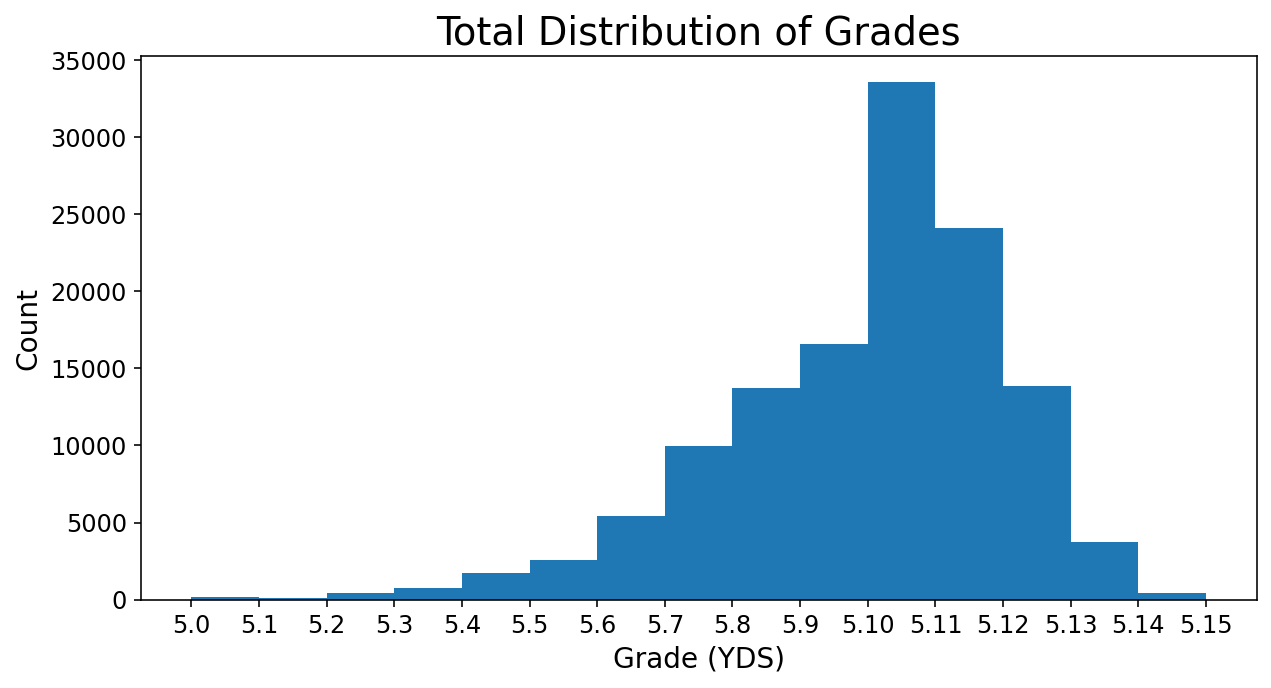

In [457]:
plt.figure(figsize=(10, 5))
plt.hist(routes['grade_reduced'], bins=range(0, 16))
plt.xticks(ticks=range(0,16), labels=grade_labels)
plt.title("Total Distribution of Grades")
plt.xlabel("Grade (YDS)")
plt.ylabel("Count")
plt.show()

Here we can see that the mass of available grades is around 5.10, with a long left tail into the easier grades. Given the ordinal nature of this problem, grades below 5.6 and above 5.12 may need to be dropped due to lack of training data.

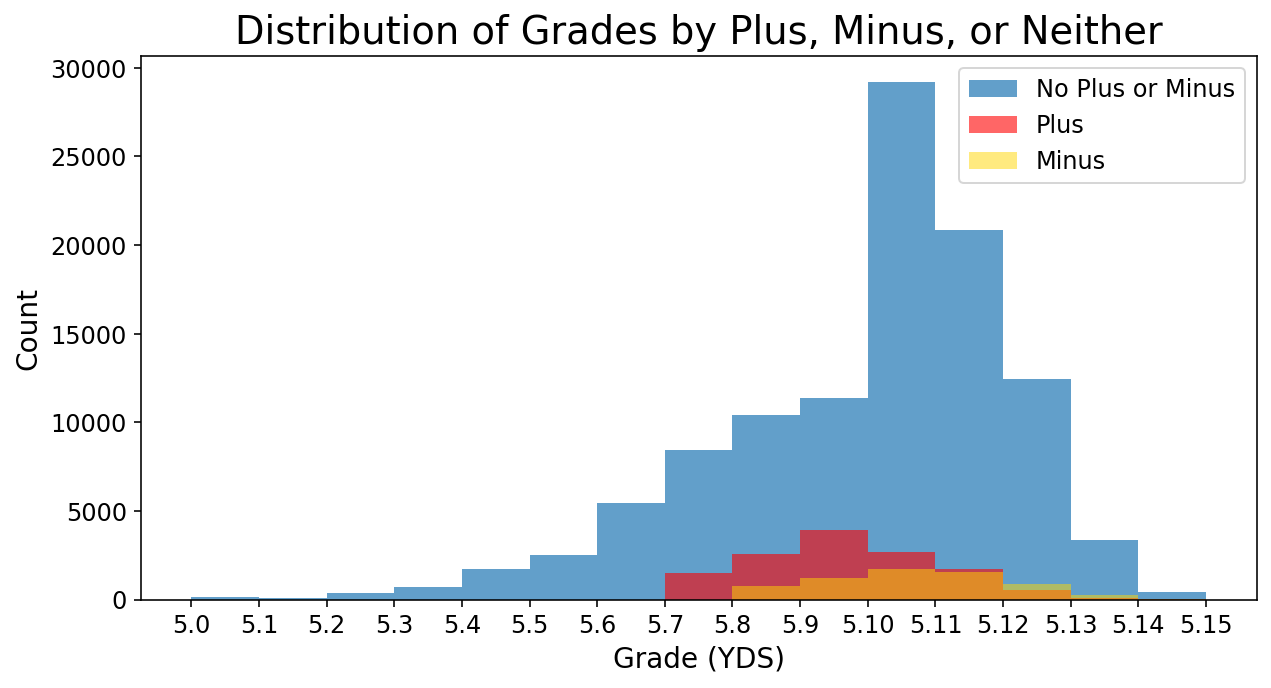

In [458]:
#distribution of grades by + or - or neither
plt.figure(figsize=(10, 5))
plt.hist(routes[routes['plus_minus'] == 0]['grade_reduced'].apply(np.floor), bins=range(0, 16), label='No Plus or Minus', alpha=.7)
plt.hist(routes[routes['plus_minus'] == 1]['grade_reduced'], bins=range(0,16), label='Plus', alpha=.6, color='r')
plt.hist(routes[routes['plus_minus'] == -1]['grade_reduced'], bins=range(0,16), label='Minus', alpha=.5, color='gold')
plt.xticks(ticks=range(0,16), labels=grade_labels)
plt.title("Distribution of Grades by Plus, Minus, or Neither")
plt.xlabel("Grade (YDS)")
plt.ylabel("Count")
plt.legend()
plt.show()

I am not surprised to see that plus-grades have a lower average grade distribution. '+' is often a feature seen on older routes that were established before grades above 5.10 were common. In grades 5.10 and above a letter grade is much more common than a plus or minus, as it is more precise.

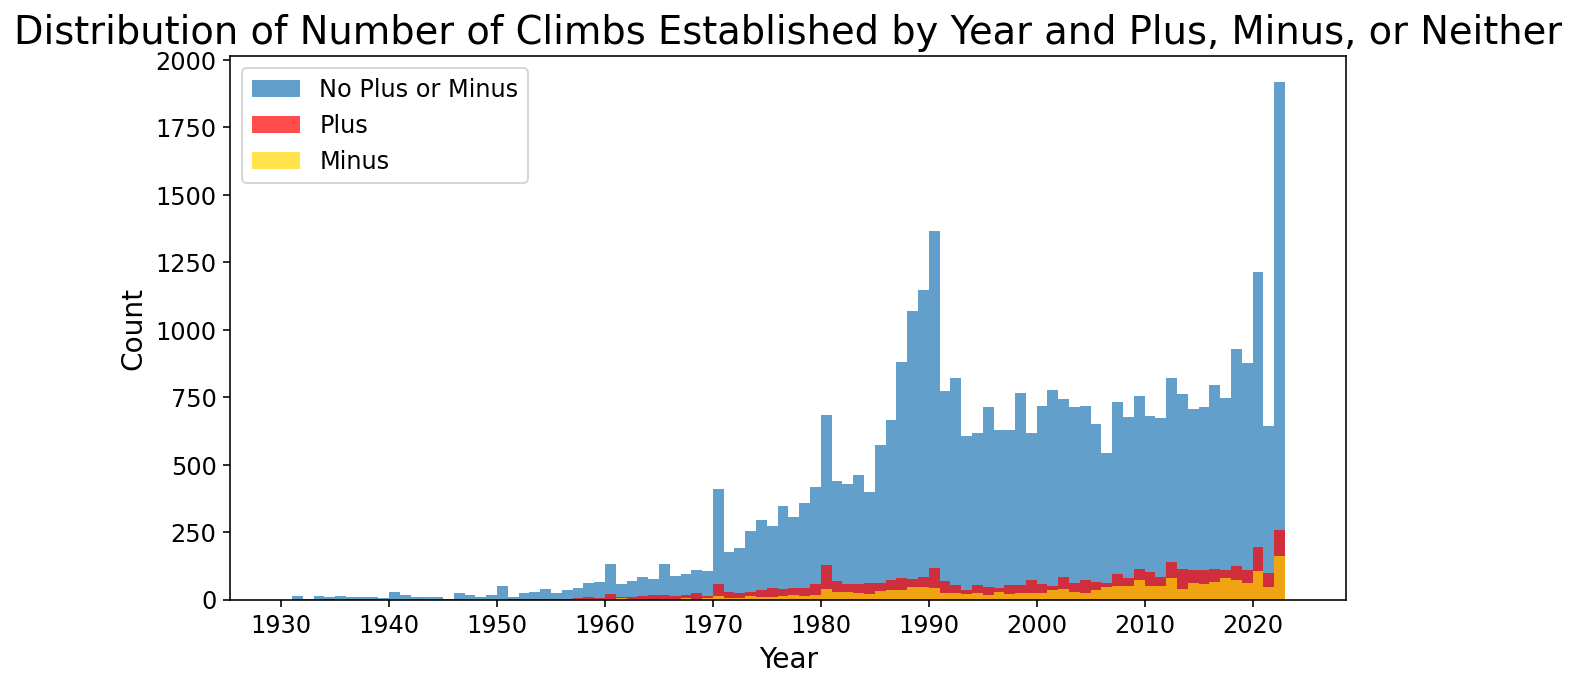

In [459]:
#distribution of +/- by year
plt.figure(figsize=(10,5))
plt.hist(routes[(routes['plus_minus'] == 0) & (routes['year_established'] > 1930)]['year_established'], label="No Plus or Minus", bins=range(1930, 2025, 1), alpha=.7)
plt.hist(routes[(routes['plus_minus'] == 1) & (routes['year_established'] > 1930)]['year_established'], label="Plus", color='r', bins=range(1930, 2025, 1), alpha=.7)
plt.hist(routes[routes['plus_minus'] == -1]['year_established'], label="Minus", color='gold', bins=range(1930, 2025, 1), alpha=.7)
plt.xticks(ticks=range(1930, 2021, 10))
plt.title("Distribution of Number of Climbs Established by Year and Plus, Minus, or Neither")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.show()

Interestingly, there seems to be an upward trend in total number of +/- grades assigned every year. This was not what I expected, so I wanted to look at the number of +/- routes in proportion to the total number of new routes every year. 

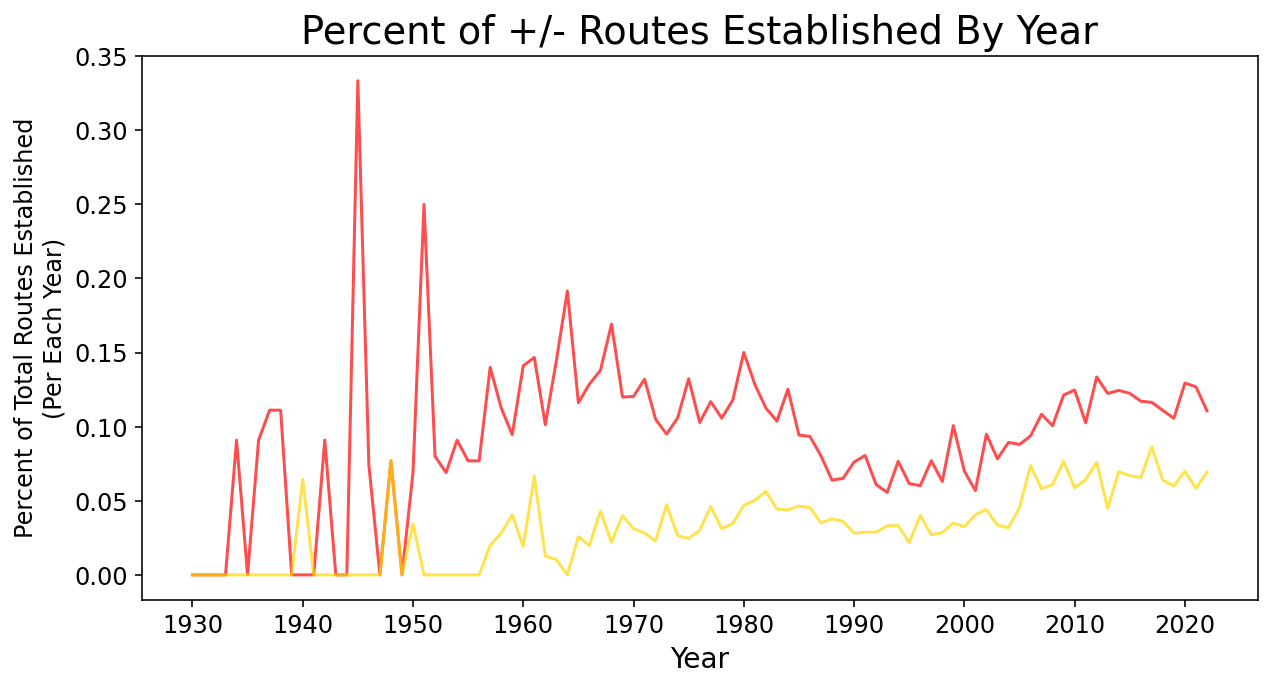

In [462]:
#plus/minus/neither as proportion of total climbs established
routes['plus'] = routes['plus_minus'].apply(lambda x: 1 if x == 1 else 0)
routes['minus'] = routes['plus_minus'].apply(lambda x: 1 if x == -1 else 0)

plt.figure(figsize=(10, 5))
plt.plot(range(1930, 2023), routes.groupby('year_established')['plus'].mean().loc[1930:], color='r', alpha=.7, label="Plus")
plt.plot(range(1930, 2023), routes.groupby('year_established')['minus'].mean().loc[1930:], color='gold', alpha=.7, label='Minus')
plt.xticks(ticks=range(1930, 2021, 10))
plt.title("Percent of +/- Routes Established By Year")
plt.xlabel("Year")
plt.ylabel("Percent of Total Routes Established\n(Per Each Year)", size=12)
plt.show()

Here I see more of the trends I was expecting, with great spikes in the use of the '+' designation earlier on, petering out a bit into the 1980s and 90s. I was not expecting, however, to see the rise in their use again starting in the early 2000s. This bimodal distribution is more clear when viewed as a proportion than it was in the larger plot above. This made me curious about the distribution of the establishment years of the 5.9+ grade specifically, as that is known to be a grade that feels much different depending on the year established.

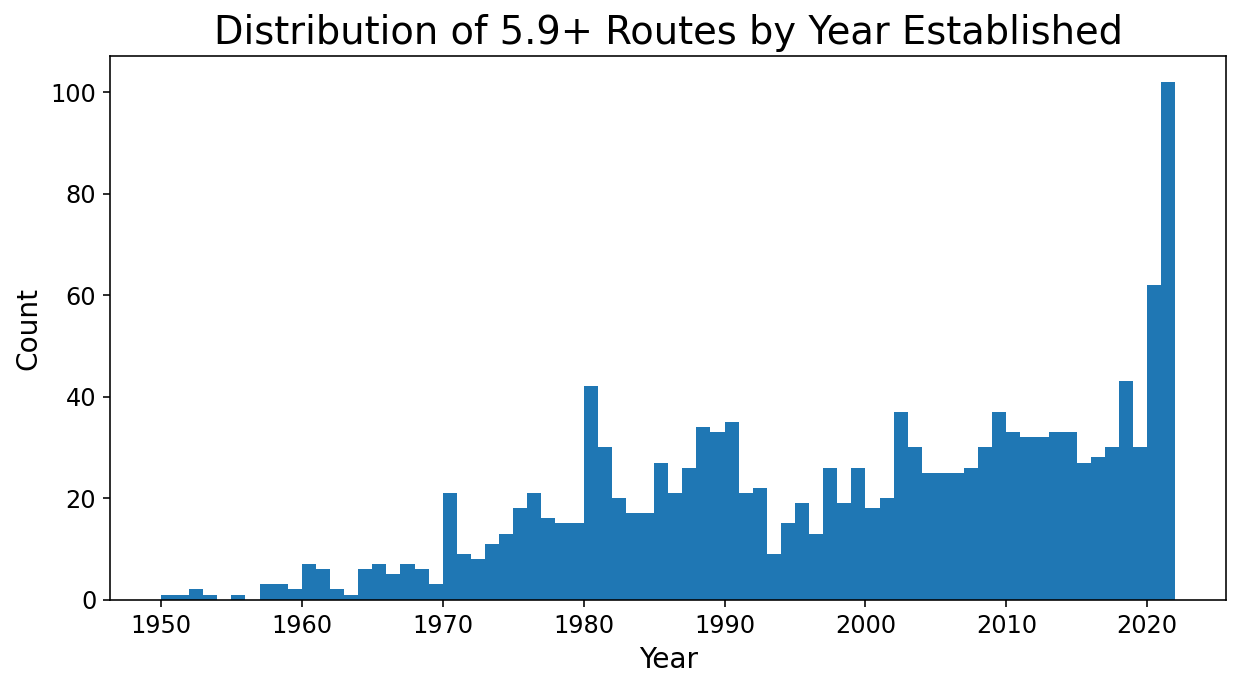

In [463]:
#distribution of 5.9+ by year, twiny https://stackoverflow.com/questions/22853118/twiny-in-matplotlib-changes-the-y-axis-scale
#plt.hist(routes[~(routes['grade.YDS'] == '5.9+')]['year_established'], bins=range(1950, 2023, 2))
plt.figure(figsize=(10,5))
plt.hist(routes[routes['grade.YDS'] == '5.9+']['year_established'], bins=range(1950, 2023, 1))
plt.title("Distribution of 5.9+ Routes by Year Established")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

In [318]:
routes[(routes['grade.YDS'] == '5.9+') & (routes['year_established'].notna())]['year_established'].median()

2001.5

A similar slightly bimodal distribution shows up here, countering the commonly-touted idea that many 5.9+ routes are older. Just as many have been established since 2001 as were established prior to that year. 

#### Distribution of Grades by Route Type
Route type is an interesting, potentially useful feature. Due to the differences in technicality in the different styles of climbing, I expect to see that there will be slightly different distributions. Sport, being the most ubiquitous style of climbing, and also where the upper limits tend to be pushed, will likely have a thinner left tail to the lower grades, while I expect to see that the more technical styles of climbing such as Ice, Snow, and Mixed will tend to center more around the lower grades, perhaps with right tails to the higher grades.

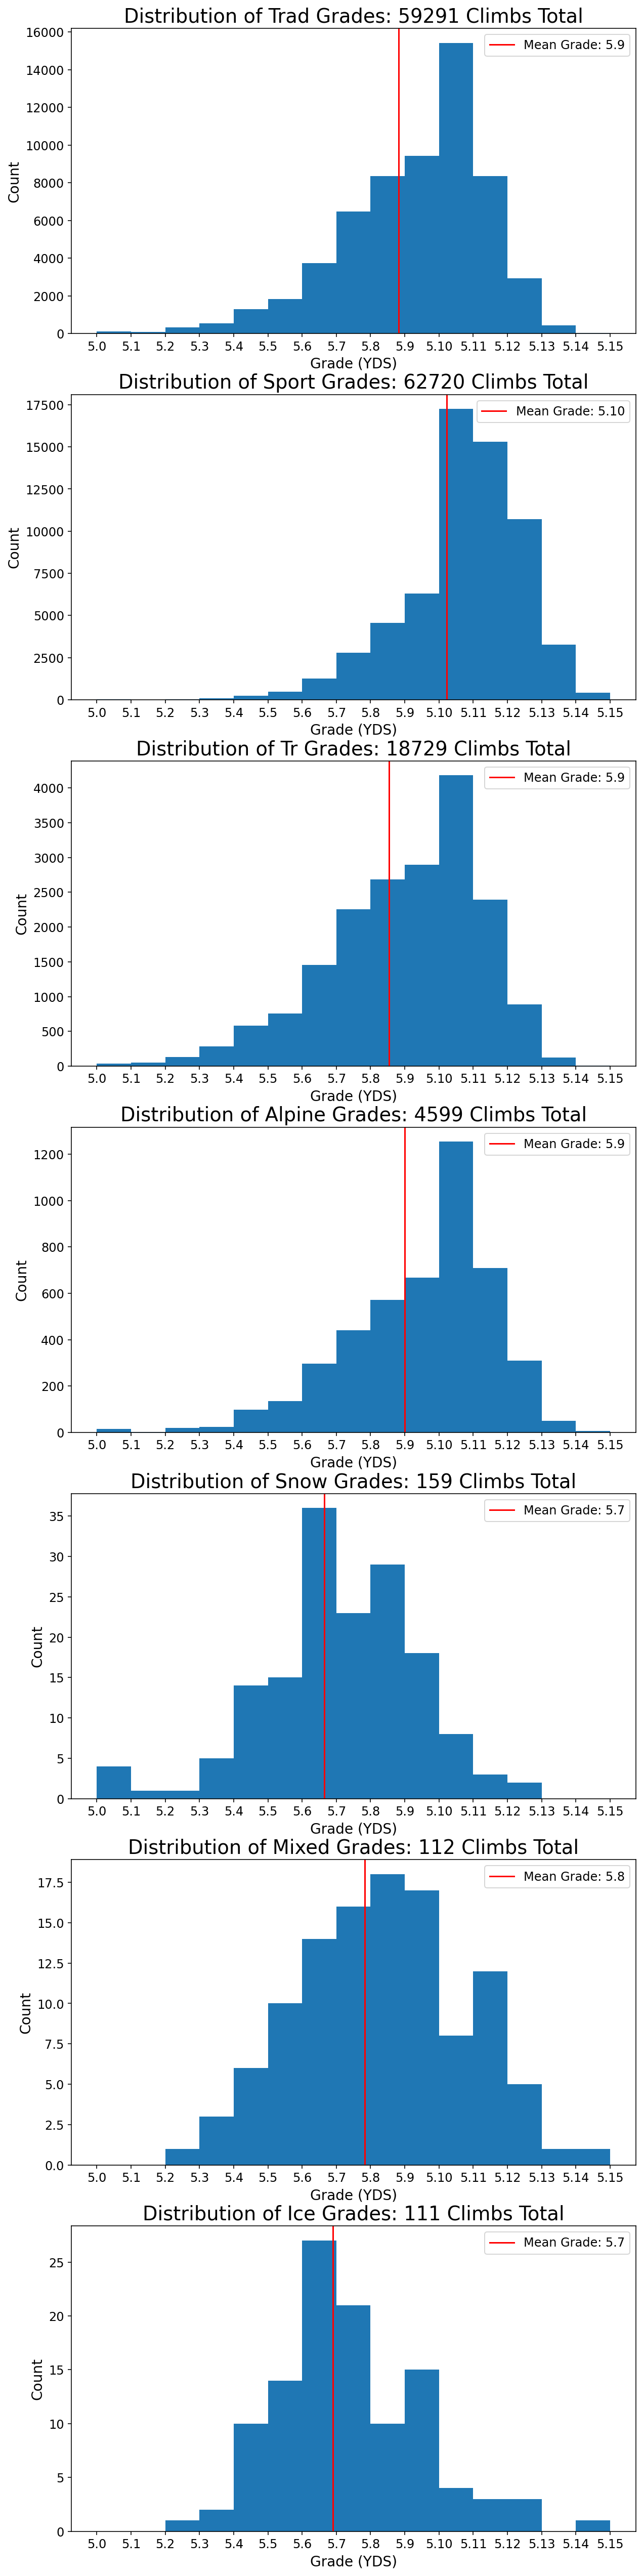

In [464]:
#distribution of grades by climb type - 7 types
type_cols = [x for x in routes.columns if "type" in x]

fig, ax = plt.subplots(len(type_cols), 1, figsize=(10, 6.5*len(type_cols)))
for i, col in enumerate(type_cols):
    col_name = col.split(".")[1].title()
    ax[i].hist(routes[routes[col] == 1]['grade_reduced'], bins=range(0,16))
    ax[i].set_xticks(ticks=range(0,16), labels=grade_labels)
    ax[i].set_title(f"Distribution of {col_name} Grades: {routes[col].sum()} Climbs Total")
    ax[i].set_xlabel("Grade (YDS)")
    ax[i].set_ylabel("Count")
    ax[i].axvline(routes[routes[col] == 1]['grade_reduced'].mean(), color='r', label=f"Mean Grade: {'5.' + str(round(routes[routes[col] == 1]['grade_reduced'].mean()))}")
    ax[i].legend()

Generally, the more difficult or high-risk the climbing, the lower the average grade, and the larger of a left tail it has. Sport is the most popular category of climbing, and also where people tend to push their skills because it is (generally) less risky, and less technical than Trad, the second most popular. General wisdom is that you should aim to climb Trad routes that are 2 grades lower than what you're used to, which is what we see playing out in the averages here.

I was a little surprised to see that Alpine had such a high average grade, and similar distribution to Trad and Toprope (Tr). Snow, Ice, and Mixed, given their technicality, were expected to have lower average grades, although the normality of the distribution, rather than a right skew, were interesting to see.

I think in the upper and lower grades these features may be helpful, but in the 5.8-5.11 range they are less likely to be.

### Baseline NLP Features
Features such as word count and character count in our combined text column may have some correlation with the target grades.

In [465]:
#double check we have no nans to deal with
routes['lemmatized_text_combined'].isna().sum()

0

In [466]:
routes["word_count"] = routes["lemmatized_text_combined"].apply(lambda x: len(x.split(" ")))
routes["char_count"] = routes["lemmatized_text_combined"].apply(lambda x: len(x))

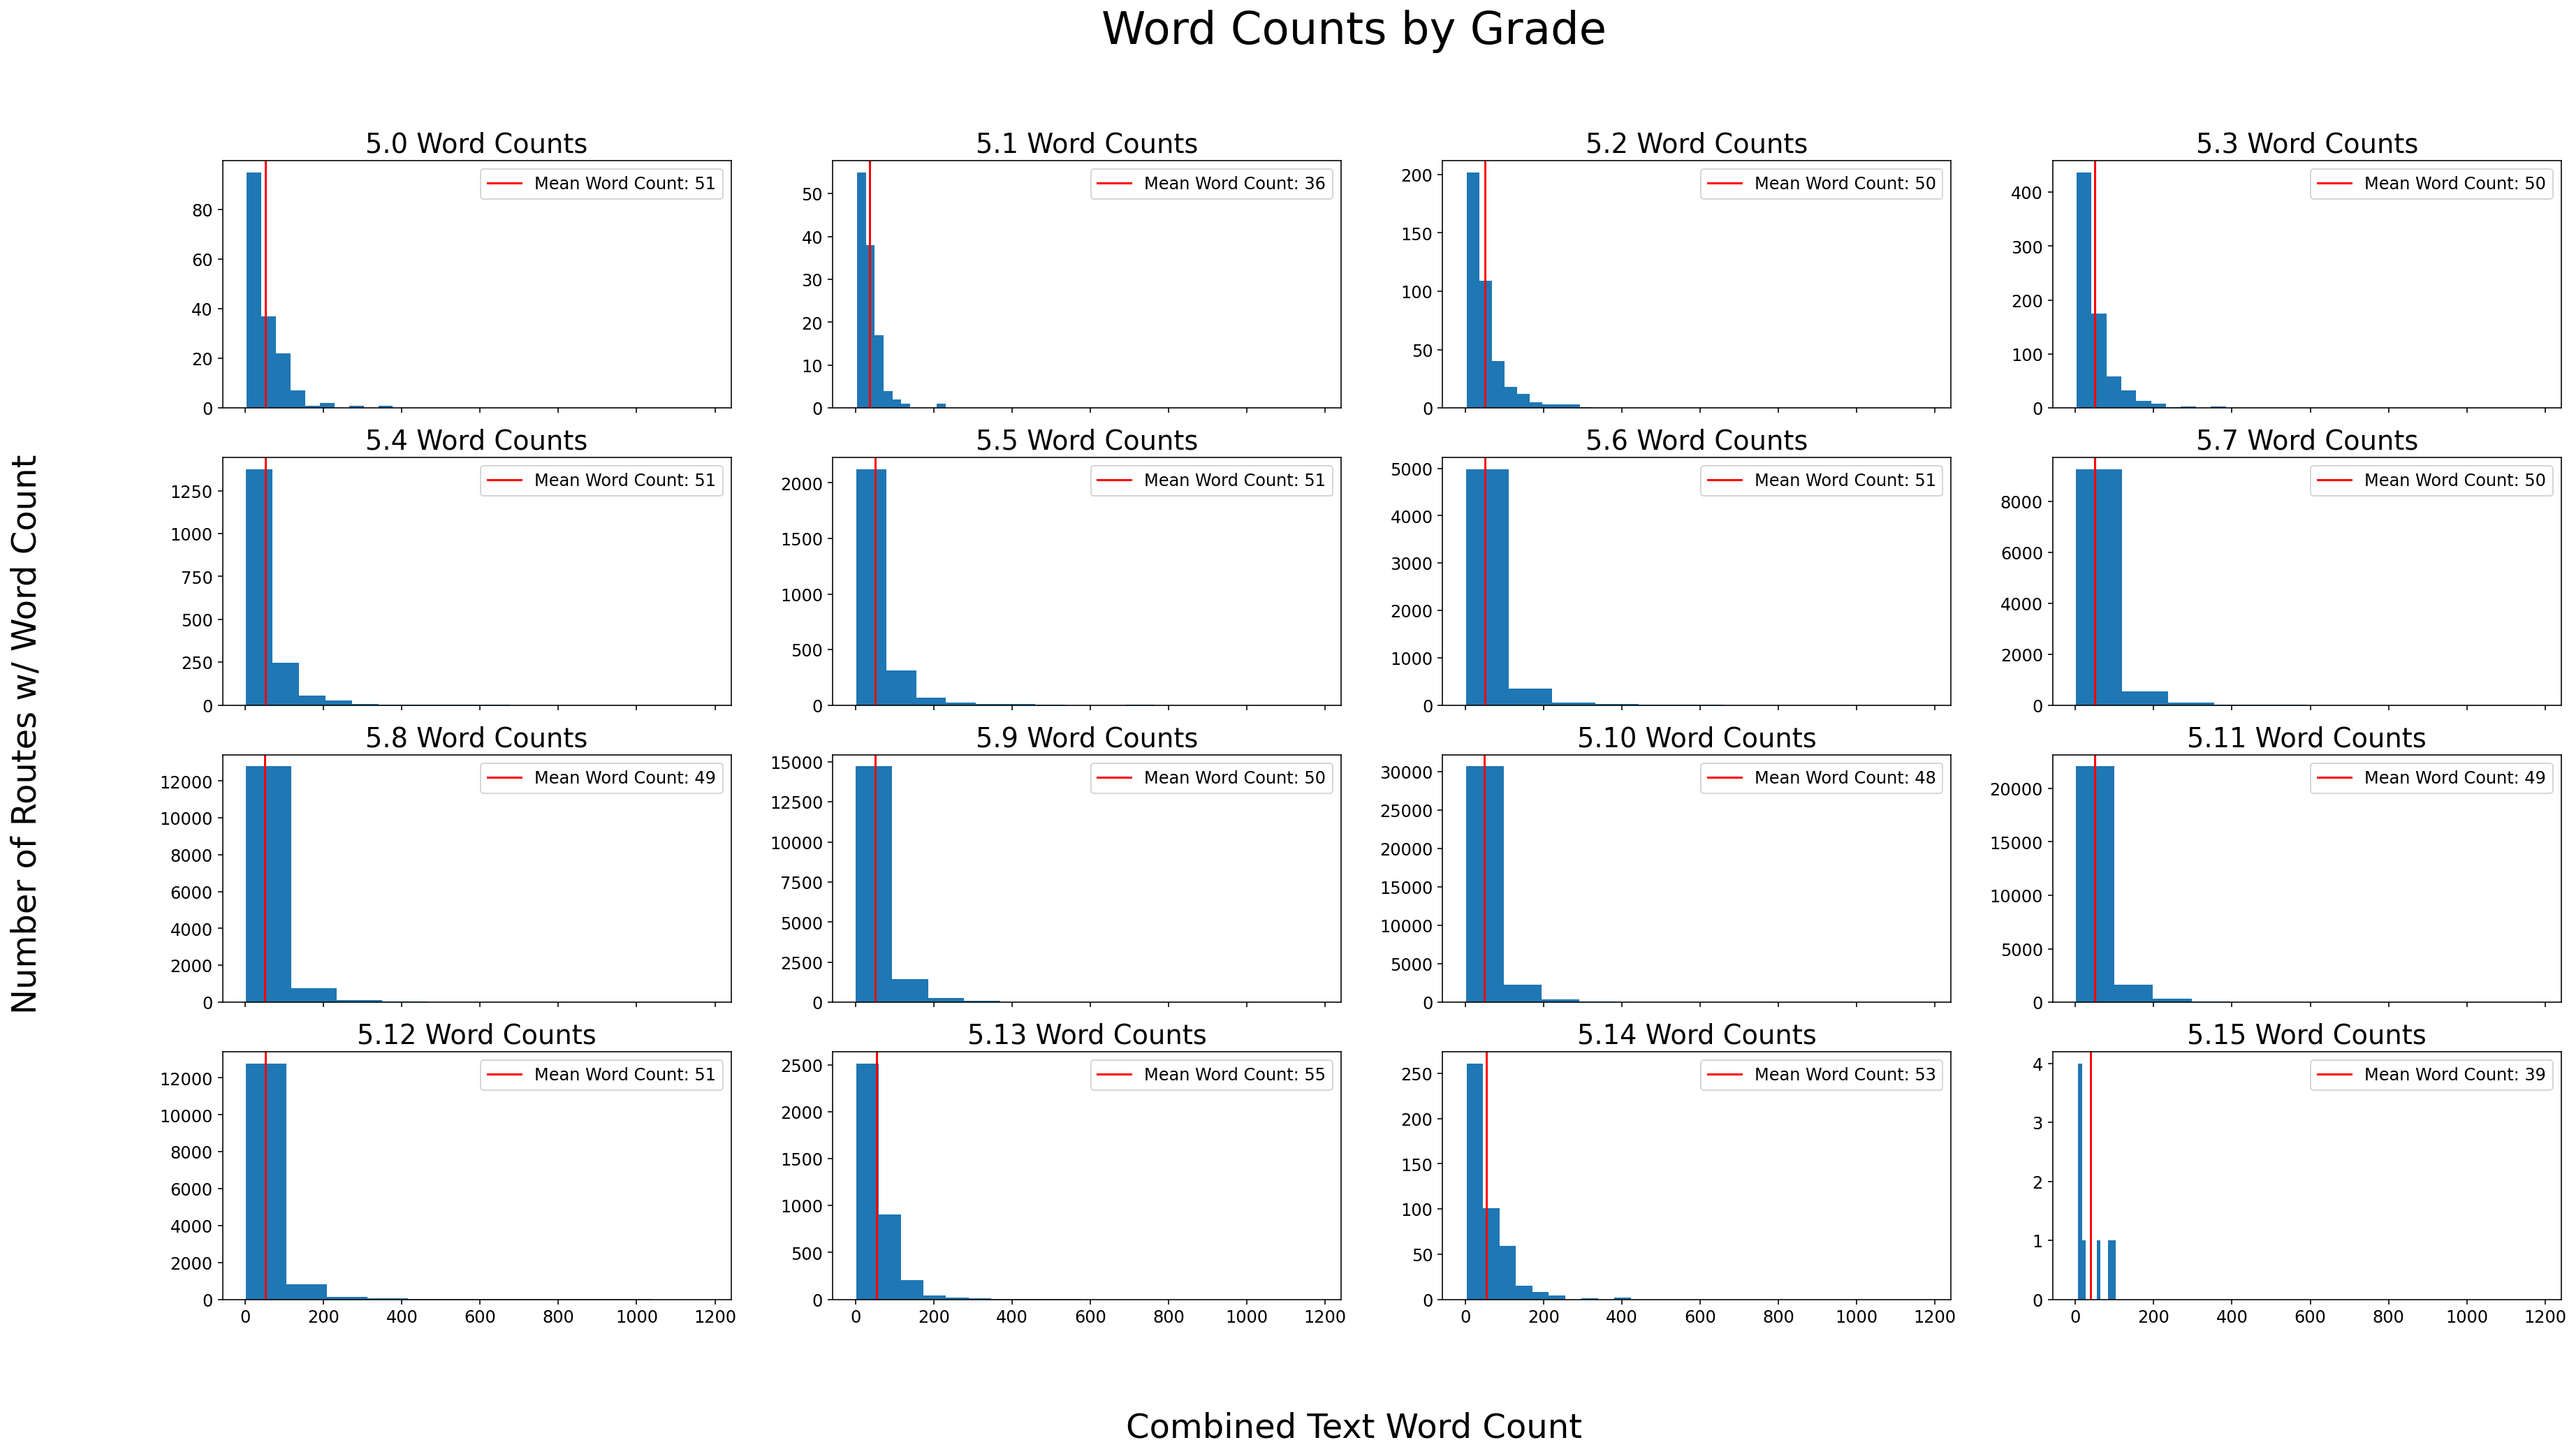

In [469]:
fig, ax = plt.subplots(4, 4, figsize=(30, 15), sharex=True, )

i = 0
j = 0
for grade, label in enumerate(grade_labels):
    ax[i,j].hist(routes[routes['grade_reduced'] == grade]['word_count'])
    ax[i,j].set_title(f"{label} Word Counts")
    mean_word_count = routes[routes['grade_reduced'] == grade]['word_count'].mean()
    ax[i,j].axvline(mean_word_count, color='r', label=f"Mean Word Count: {round(mean_word_count)}")
    ax[i,j].legend()
    
    #increment ax
    if (j + 1) % 4 == 0:
        i += 1
        j = 0
    else: 
        j += 1

# Set common labels - https://stackoverflow.com/questions/6963035/pyplot-common-axes-labels-for-subplots
fig.suptitle("Word Counts by Grade", size=32)
fig.text(0.5, 0.04, 'Combined Text Word Count', ha='center', va='center', size=24)
fig.text(0.06, 0.5, 'Number of Routes w/ Word Count', ha='center', va='center', rotation='vertical', size=24)
plt.show()

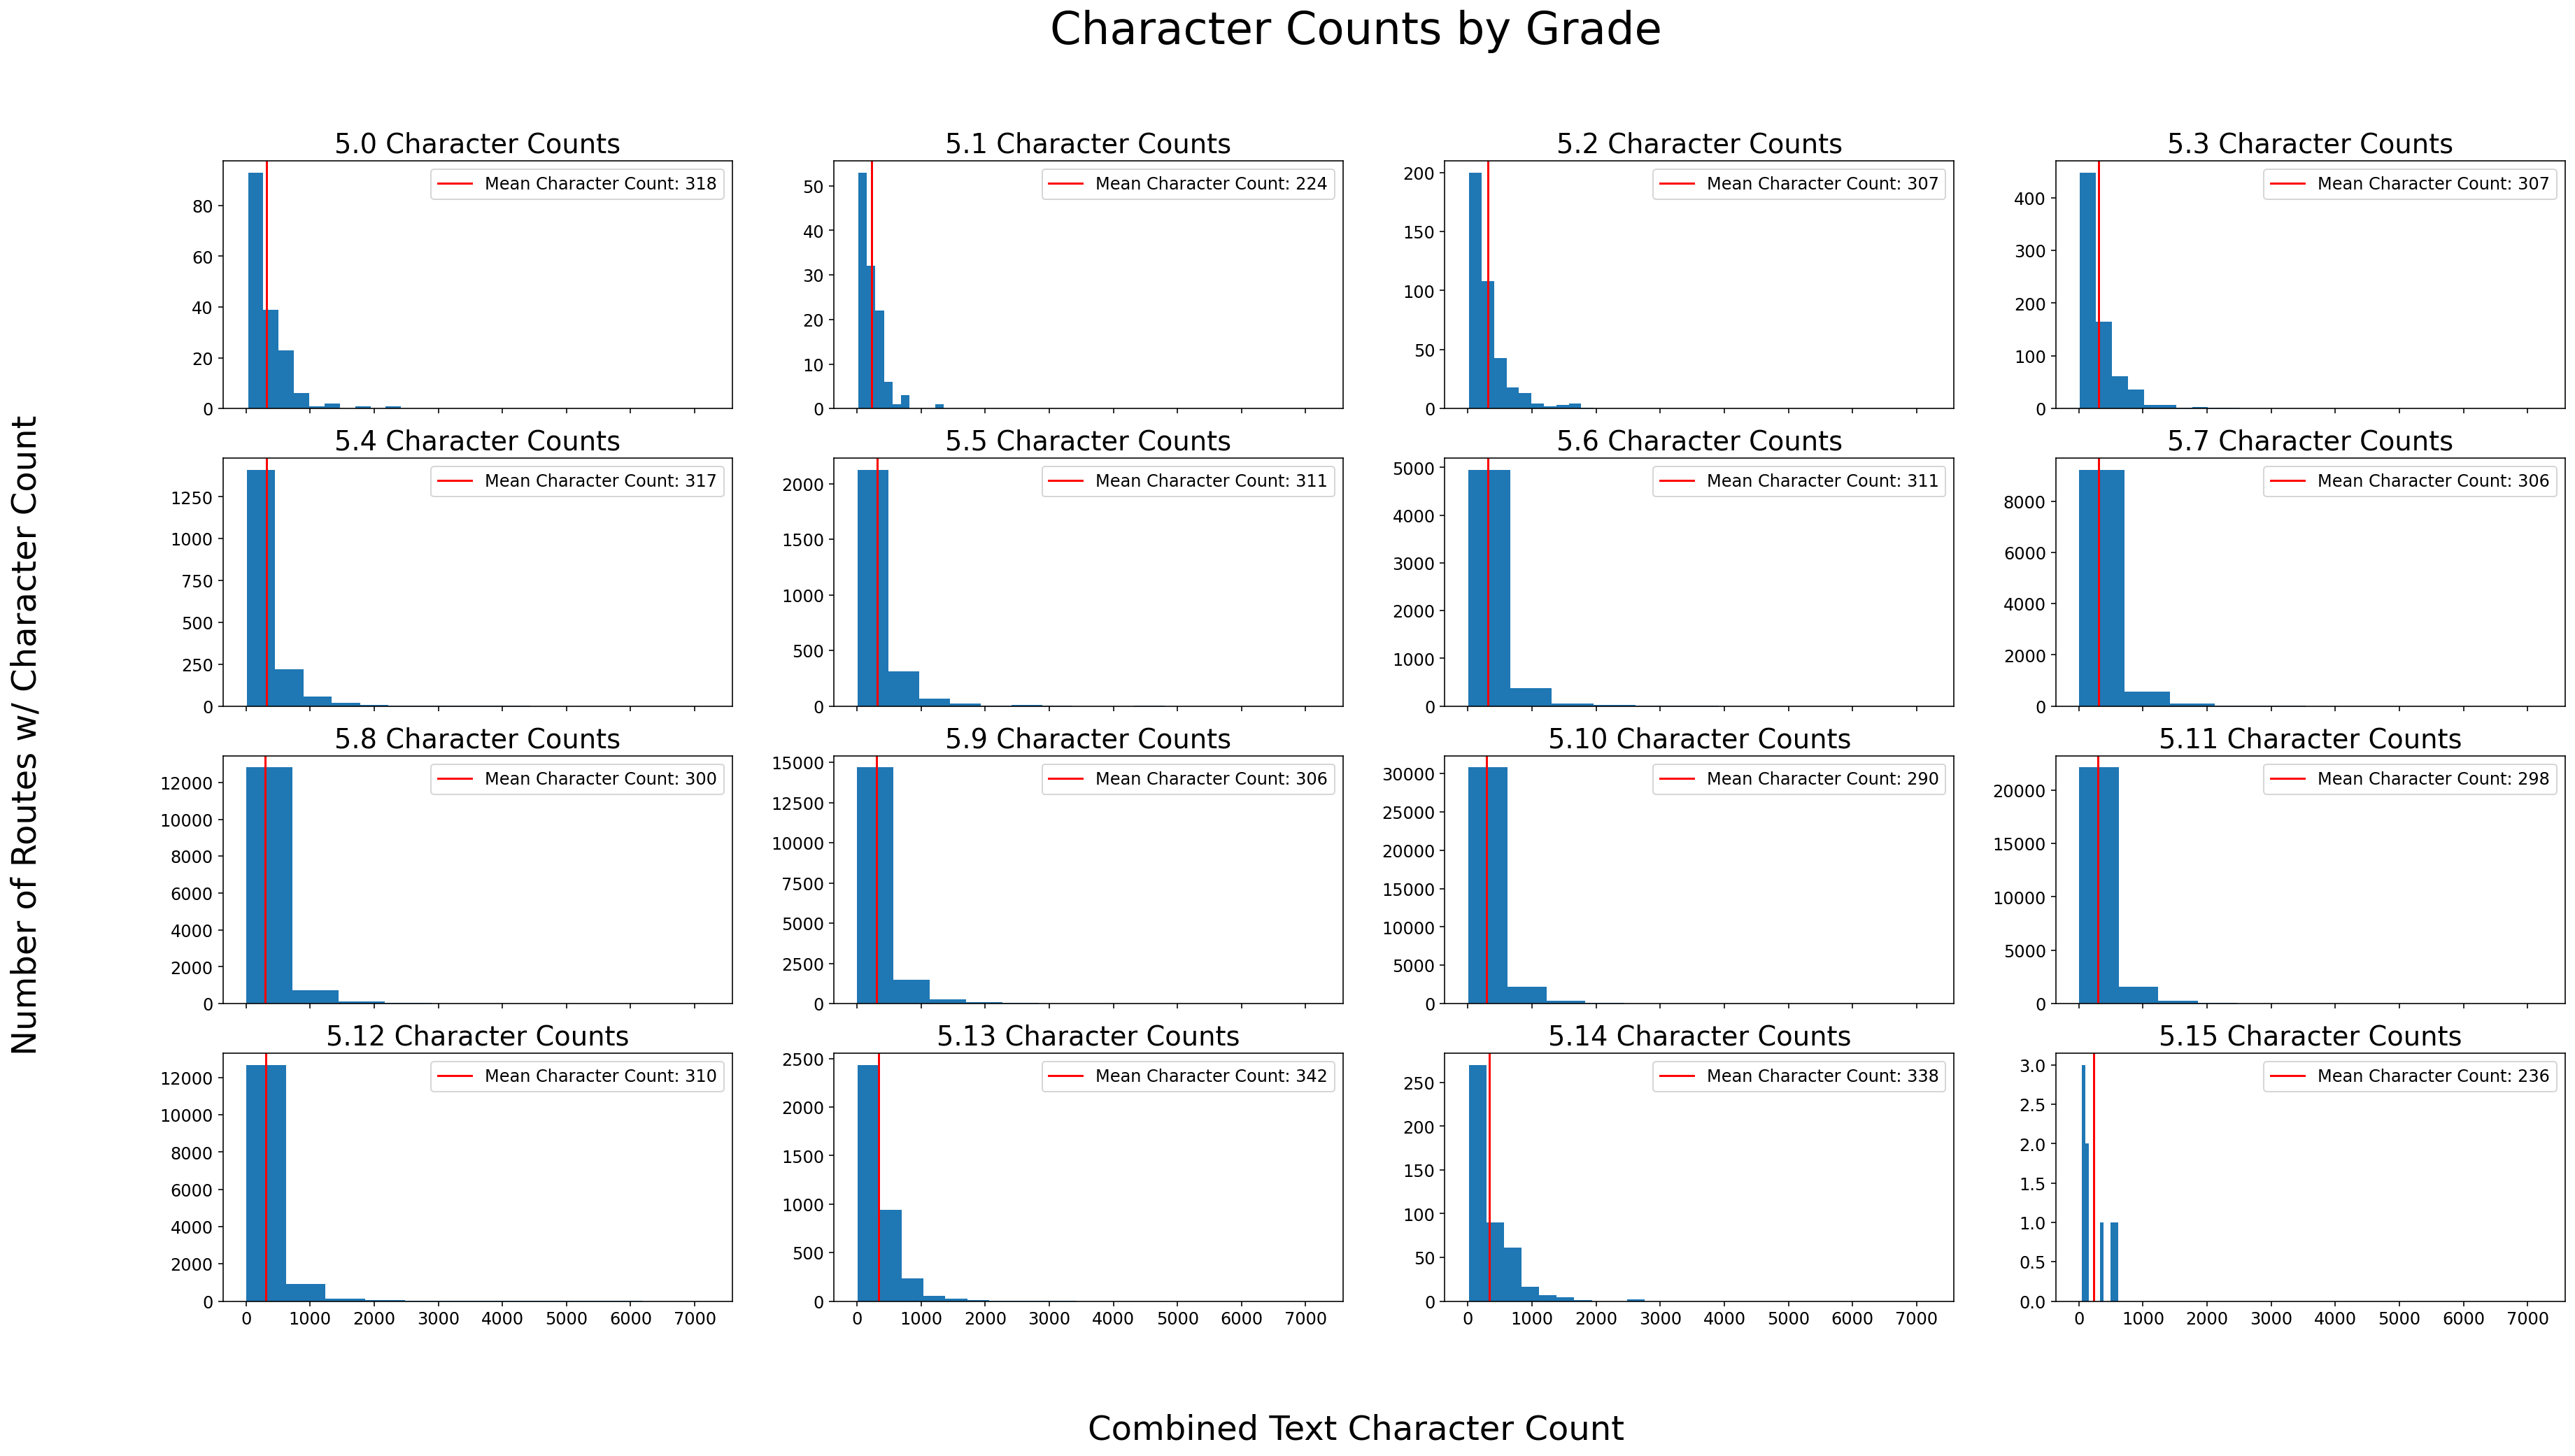

In [470]:
fig, ax = plt.subplots(4, 4, figsize=(30, 15), sharex=True, )

i = 0
j = 0
for grade, label in enumerate(grade_labels):
    ax[i,j].hist(routes[routes['grade_reduced'] == grade]['char_count'])
    ax[i,j].set_title(f"{label} Character Counts")
    mean_char_count = routes[routes['grade_reduced'] == grade]['char_count'].mean()
    ax[i,j].axvline(mean_char_count, color='r', label=f"Mean Character Count: {round(mean_char_count)}")
    ax[i,j].legend()
    
    #increment ax
    if (j + 1) % 4 == 0:
        i += 1
        j = 0
    else: 
        j += 1

# Set common labels - https://stackoverflow.com/questions/6963035/pyplot-common-axes-labels-for-subplots
fig.suptitle("Character Counts by Grade", size=32)
fig.text(0.5, 0.04, 'Combined Text Character Count', ha='center', va='center', size=24)
fig.text(0.06, 0.5, 'Number of Routes w/ Character Count', ha='center', va='center', rotation='vertical', size=24)
plt.show()

### Correlation - With NLP Count Features

In [471]:
routes.corr()['grade_reduced'].sort_values(key=abs, ascending=False)

grade_reduced            1.000000
type.sport               0.351480
type.trad               -0.301838
type.tr                 -0.190652
year_established         0.122195
plus_minus              -0.083169
minus                    0.081219
type.snow               -0.048450
plus                    -0.047663
metadata.mp_sector_id   -0.046796
type.alpine             -0.045173
type.ice                -0.036998
type.mixed              -0.023738
metadata.mp_route_id    -0.007640
char_count               0.000159
word_count               0.000056
Name: grade_reduced, dtype: float64

Good signs here for our route type features. Although 30% correlation is not ideal, it's good to see that some features are above 10% (positive and negative agnostic). Year established also shows a slightly higher correlation, but only at 12% (and again, is only for 1/3 of the dataset).

#### Vectorizers


In [476]:
#count vectorizer - remove stop words
cvec = CountVectorizer(stop_words='english', min_df=10)
cvec_df = pd.DataFrame(cvec.fit_transform(routes['lemmatized_text_combined']).todense(), columns=cvec.get_feature_names_out())

In [477]:
#top most common words
cvec_df.sum().sort_values(ascending=False).head(10)

bolt      219836
right     156986
climb     136222
route     128130
anchor    122529
crack     107799
face       91818
leave      83652
start      81124
left       69592
dtype: int64

In [479]:
#add max document frequency?
tfidf = TfidfVectorizer(stop_words='english', min_df=10)
tfidf_df = pd.DataFrame(tfidf.fit_transform(spacy_routes['lemmatized_text_combined']).todense(), columns=tfidf.get_feature_names_out())
tfidf_df = tfidf_df.drop(columns='nan')

#most impactful words
tfidf_df.mean().sort_values(ascending=False).head(10)

bolt      0.082066
right     0.055639
climb     0.050008
anchor    0.049976
route     0.049823
crack     0.048562
face      0.042300
leave     0.036370
start     0.036338
left      0.034442
dtype: float64

In [480]:
#merge in labels
tfidf_df = pd.concat([tfidf_df, routes['grade_reduced']], axis=1)

In [481]:
tfidf_df['grade_reduced'].value_counts()

10.0    33577
11.0    24114
9.0     16556
12.0    13829
8.0     13715
7.0      9953
6.0      5424
13.0     3710
5.0      2538
4.0      1722
3.0       731
14.0      451
2.0       396
0.0       166
1.0       118
15.0        8
Name: grade_reduced, dtype: int64

In [482]:
grouped = tfidf_df.groupby(by='grade_reduced').mean()
grouped.index = [str(x) for x in grouped.index]
grouped = grouped.loc[sorted(grouped.index, key=lambda x: int(x.split(".")[1]))]
for grade in grouped.index:
    print(f"{grade} Top 10:")
    print(grouped.loc[grade].sort_values(ascending=False).head(10))
    print()

0.0 Top 10:
crack     0.063903
bolt      0.063624
climb     0.058248
face      0.054184
right     0.051488
route     0.045031
leave     0.041787
left      0.038313
anchor    0.037634
start     0.036893
Name: 0.0, dtype: float64

1.0 Top 10:
bolt      0.080288
right     0.058648
crack     0.054866
route     0.051311
anchor    0.046281
climb     0.046004
face      0.043731
left      0.037012
leave     0.036363
start     0.033762
Name: 1.0, dtype: float64

2.0 Top 10:
bolt      0.060384
right     0.057611
face      0.053943
crack     0.049687
climb     0.049550
route     0.044249
corner    0.041244
anchor    0.040361
leave     0.037220
left      0.036247
Name: 2.0, dtype: float64

3.0 Top 10:
right     0.061083
crack     0.059983
bolt      0.059707
climb     0.055271
face      0.051832
leave     0.043287
route     0.042019
anchor    0.041992
left      0.036552
start     0.035333
Name: 3.0, dtype: float64

4.0 Top 10:
bolt      0.066493
right     0.058934
climb     0.052938
crack     0.051

In [ ]:
#group by 

### NLP Cleaning
- transfer learning approach - bert
- document embedding? average of word vectors?
- have to find which method will give the best feature matrix
    - depends on the model!
    - best matrix depends on how well that matrix improves your model
- transfer learning - build baseline models with easy ones, and then build same models with better ones

- word2vec, doc2vec, bert EDA

- EDA - using vectorizers to find some insight into the actual words
- Deep EDA - document embedding - each description is a vector, can figure out how similar different documents are. Can also make word vectors - SNE stochastic neighborhood embedding, gives us visual clusters of words 
- ordinal regression not necessarily necessary, but it will learn better how the grades should be embedded onto the real number line.
    - probably use the labels and not the numeric mapping of the grades
    
- spaCy for NLP EDA!

### NLP Methods
#### Document Embedding


#### fastText
[Advances in Pre-Training Distributed Word Representation
s](https://arxiv.org/pdf/1712.09405.pdf)
Position dependent weighting of word vectors: 
>Each position p in a context window is associated with
a vector dp. The context vector is then the average of
the context words reweighted by their position vectors.
More precisely, denoting by P the set of relative positions
[−c, . . . , −1, 1, . . . , c] in the context window, the context
vector vC of the word wt is:
vC =
X
p∈P
dp ⊙ ut+p, (5)
where ⊙ is the pointwise multiplication of vectors.

>We decided to perform no complex data normalization or
pre-processing, as we want the resulting word vectors to be
very easily used by a wide community (the text normalization can be done on top of the published word vectors as
a post-processing step). 

[fastText tutorial for transfer learning](https://fasttext.cc/docs/en/supervised-tutorial.html)
[using hierarchical softmax is faster](https://fasttext.cc/docs/en/supervised-tutorial.html#advanced-readers-hierarchical-softmax) but this is not an ordinal model!

[learning word vectors with fastText](https://fasttext.cc/docs/en/unsupervised-tutorial.html) I don't think this is what we need??

